In [34]:
import matplotlib.pyplot as plt
import ticktack
import numpy as np
import jax.numpy as jnp
from jax import jit


In [35]:

cbm = ticktack.load_presaved_model('Guttler14', production_rate_units='atoms/cm^2/s')
cbm.compile()



# ignore error of Warning:absl:No GPU/TPU found
start = 760
resolution = 1000
burn_in_time = np.linspace(760 - 1000, 760, resolution)
steady_state_burn_in = cbm.equilibrate(target_C_14=707)
burn_in_solutions = cbm.equilibrate(production_rate=steady_state_burn_in)
d_14_time_series_fine = np.linspace(760, 788, 2700)
d_14_time_series_coarse = np.arange(760, 788)


In [47]:
@jit 
def sg(t,start_time, duration, area):
    middle = start_time+duration/2.
    height = 1./1.889*area/duration
    return height*jnp.exp(- ((t-middle)/duration)**8.)

@jit
def miyake_event(t, start_time, duration, phase, area):
#     height = jnp.where(((t > start_time) * (t < (start_time + duration))), area / duration, 0)
    height = sg(t, start_time, duration, area)
    prod =  steady_state_burn_in + 0.18 * steady_state_burn_in * jnp.sin(2 * np.pi / 11 * t + phase) + height
    return prod



In [48]:
burn_in, _ = cbm.run(burn_in_time, production=miyake_event, args=(775, 1 / 12, np.pi / 2, 81 / 12),
                     y0=burn_in_solutions)


In [49]:
prod = miyake_event(d_14_time_series_fine,775, 1 / 12, np.pi / 2, 81 / 12)

event, _ = cbm.run(d_14_time_series_fine, production=miyake_event, args=(775, 1 / 12, np.pi / 2, 81 / 12),
                   y0=burn_in[-1, :])
d_14_c = cbm.run_D_14_C_values(d_14_time_series_coarse, 1000, production=miyake_event,
                               args=(775, 1 / 12, np.pi / 2, 81 / 12),
                               y0=burn_in[-1, :], steady_state_solutions=burn_in_solutions)


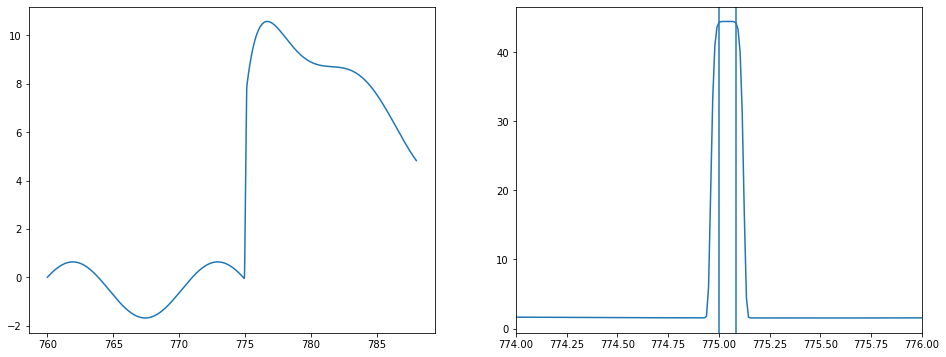

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16.0,6.0))
ax1.plot(d_14_time_series_fine, event[:, 1]-event[0, 1])
# ax1.plot(d_14_time_series_coarse[0:-1], d_14_c, 'o')
ax2.plot(d_14_time_series_fine,prod)
ax2.set_xlim(774,776)
plt.axvline(775)
plt.axvline(775+ 1 / 12)
# ax2.set_ylim(0,5)

plt.ticklabel_format(useOffset=False)

plt.show()